In [1]:
import os
import sys
import pathlib
import pickle as pkl
import json
import itertools

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from datasets import deep_fashion
from arch import backbones, heads, models

from tqdm import tqdm

import utils.time
import utils.dict

from time import time
from datetime import datetime

import pprint

In [2]:
def load_json_dict(
        json_filename
        ):

    with open(json_filename, 'r') as json_file:
        json_dict = json.load(json_file)

    return json_dict

---

In [3]:
exp_dirname = os.path.join(pathlib.Path.home(), "data", "fashion_retrieval", "ret_train")

backbones = ["resnet_50", "efficientnet_b3", "convnext_t"]
num_exps_list = [9, 13, 13]

df_records = []

for backbone, num_exps in zip(backbones, num_exps_list):
    for exp_idx in range(num_exps):

        eval_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "eval_ctsrbm_data.json")
        eval_data = load_json_dict(eval_filename)

        exp_filename = os.path.join(exp_dirname, backbone, "test_{:03d}".format(exp_idx), "exp_data.json")
        exp_data = load_json_dict(exp_filename)

        df_record = {}

        # exp_data

        df_record["backbone"] = exp_data["settings"]["backbone"]["class"]

        stage_1_batch_size = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
        stage_2_batch_size = exp_data["settings"]["stage_2"]["data_loading"]["batch_size"]

        stage_1_max_acc_iter = utils.dict.chain_get(
            exp_data,
            "settings", "stage_1", "max_acc_iter",
            default=1
        )
        stage_2_max_acc_iter = utils.dict.chain_get(
            exp_data,
            "settings", "stage_2", "max_acc_iter",
            default=1
        )

        df_record["loading_batch_size"] = stage_1_batch_size * stage_1_max_acc_iter

        df_record["stage_1_grad_acc_iters"] = stage_1_max_acc_iter
        df_record["stage_2_grad_acc_iters"] = stage_2_max_acc_iter

        df_record["stage_1_lr"] = exp_data["settings"]["stage_1"]["optimizer"]["lr"]
        df_record["stage_2_lr"] = exp_data["settings"]["stage_2"]["optimizer"]["lr"]

        df_record["num_gpus"] = len(exp_data["settings"]["gpu_usage"])
        
        # eval_data

        splits = ["test", "train", "val"]
        metrics = ["p", "r", "f1"]

        for split, metric in itertools.product(splits, metrics):

            value_key = "avg_{:s}_at_k_dict".format(metric)
            value_dict = eval_data["results"][split][value_key]

            for key, item in value_dict.items():

                column_name = "avg_{:s}_{:s}_at_{:s}".format(split, metric, key)
                df_record[column_name] = item

        df_records.append(df_record)
        

FileNotFoundError: [Errno 2] No such file or directory: '/home-net/gortega/data/fashion_retrieval/ret_train/resnet_50/test_000/eval_ctsrbm_data.json'

In [34]:
df = pd.DataFrame.from_records(df_records)

In [35]:
df

,backbone,loading_batch_size,stage_1_grad_acc_iters,stage_2_grad_acc_iters,stage_1_lr,stage_2_lr,num_gpus,avg_test_p_at_3,avg_test_p_at_5,avg_test_p_at_10,...,avg_train_f1_at_10,avg_val_p_at_3,avg_val_p_at_5,avg_val_p_at_10,avg_val_r_at_3,avg_val_r_at_5,avg_val_r_at_10,avg_val_f1_at_3,avg_val_f1_at_5,avg_val_f1_at_10
0,ResNet50Backbone,32,1,1,0.00100,0.000500,6,0.032171,0.024459,0.016554,...,0.023219,0.031151,0.023410,0.015804,0.067998,0.084323,0.113005,0.042728,0.036646,0.027729
1,ResNet50Backbone,32,1,1,0.00010,0.000050,6,0.028981,0.022115,0.014939,...,0.020212,0.028692,0.021415,0.014538,0.062477,0.077029,0.103989,0.039325,0.033513,0.025510
2,ResNet50Backbone,32,1,1,0.00001,0.000005,6,0.028657,0.021234,0.013982,...,0.018777,0.027758,0.020722,0.013559,0.059807,0.073684,0.095596,0.037917,0.032348,0.023750
3,ResNet50Backbone,16,1,1,0.00100,0.000500,6,0.034434,0.026121,0.017555,...,0.025159,0.033981,0.025565,0.017075,0.073982,0.092052,0.121667,0.046571,0.040017,0.029947
4,ResNet50Backbone,16,1,1,0.00010,0.000050,6,0.030414,0.023043,0.015590,...,0.021311,0.029097,0.022078,0.014887,0.063607,0.079481,0.105745,0.039929,0.034557,0.026099
5,ResNet50Backbone,16,1,1,0.00001,0.000005,6,0.030414,0.022781,0.015284,...,0.020530,0.029770,0.021930,0.014497,0.064534,0.078485,0.102327,0.040745,0.034281,0.025396
6,ResNet50Backbone,8,1,1,0.00100,0.000500,6,0.040231,0.030139,0.020213,...,0.027551,0.039621,0.029534,0.019482,0.086256,0.106212,0.138329,0.054299,0.046217,0.034154
7,ResNet50Backbone,8,1,1,0.00010,0.000050,6,0.031019,0.023861,0.016260,...,0.022013,0.030121,0.022849,0.015783,0.065861,0.082431,0.112440,0.041337,0.035780,0.027680
8,ResNet50Backbone,8,1,1,0.00001,0.000005,6,0.032305,0.024118,0.016060,...,0.022232,0.031625,0.023599,0.015649,0.068631,0.084711,0.111069,0.043298,0.036915,0.027433
9,EfficientNetB3Backbone,16,1,2,0.00100,0.000010,4,0.029669,0.022853,0.015571,...,0.021763,0.028280,0.021844,0.015136,0.060296,0.076985,0.105439,0.038502,0.034031,0.026472


In [27]:
df_2 = df.copy()

metric_name = "avg_test_p_at_3"

df_2 = df_2.sort_values(metric_name, ascending=False)
df_2 = df_2[[
    "backbone",
    "loading_batch_size",
    "stage_1_grad_acc_iters",
    "stage_2_grad_acc_iters",
    "stage_1_lr",
    "stage_2_lr",
    "num_gpus",
    metric_name
]]

df_2

,backbone,loading_batch_size,stage_1_grad_acc_iters,stage_2_grad_acc_iters,stage_1_lr,stage_2_lr,num_gpus,avg_test_p_at_3
23,ConvNeXtTinyBackbone,16,1,1,0.01000,0.000010,4,0.054799
27,ConvNeXtTinyBackbone,32,1,1,0.01000,0.000010,4,0.051995
21,ConvNeXtTinyBackbone,16,1,1,0.00100,0.000010,4,0.051166
33,ConvNeXtTinyBackbone,16,1,2,0.00100,0.000010,8,0.050175
31,ConvNeXtTinyBackbone,64,1,2,0.01000,0.000010,4,0.048067
24,ConvNeXtTinyBackbone,16,1,1,0.01000,0.000001,4,0.047512
25,ConvNeXtTinyBackbone,32,1,1,0.00100,0.000010,4,0.047280
28,ConvNeXtTinyBackbone,32,1,1,0.01000,0.000001,4,0.044968
29,ConvNeXtTinyBackbone,64,1,2,0.00100,0.000010,4,0.044778
22,ConvNeXtTinyBackbone,16,1,1,0.00100,0.000001,4,0.043246


---

# Extra

In [ ]:
ord_df = df.sort_values("avg_test_f1_at_same", ascending=True)
ord_df = ord_df.reset_index(drop=True)

In [ ]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([255/256, 153/256, 0/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_same"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_same"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_same"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @ Number of shop domain images")

###

plt.show()

In [ ]:
print("\\begin{tabular}{l", end="")
for _ in range(len(ord_df)):
    print("c", end="")
print("}", end="")
print()

###

print("Batch Size", end="")
for batch_size in ord_df["loading_batch_size"]:
    print(" & {:d}".format(batch_size), end="")
print(" \\\\")

###

print("Grad Accum. Iters", end="")
for stage_1_grad_acc_iters, stage_2_grad_acc_iters in zip(ord_df["stage_1_grad_acc_iters"], ord_df["stage_2_grad_acc_iters"]):
    print(" & {:d}".format(stage_2_grad_acc_iters), end="")
print(" \\\\")

###

print("Learning Rate (S1)", end="")
for stage_1_lr in ord_df["stage_1_lr"]:
    print(" & {:.1e}".format(float(stage_1_lr)), end="")
print(" \\\\")

###

print("Learning Rate (S2)", end="")
for stage_2_lr in ord_df["stage_2_lr"]:
    print(" & {:.1e}".format(float(stage_2_lr)), end="")
print(" \\\\")

###

print("Number of GPUs", end="")
for num_gpus in ord_df["num_gpus"]:
    print(" & {:d}".format(num_gpus), end="")

In [60]:
ord_df = df.sort_values("avg_test_f1_at_3", ascending=True)
ord_df = ord_df.reset_index(drop=True)

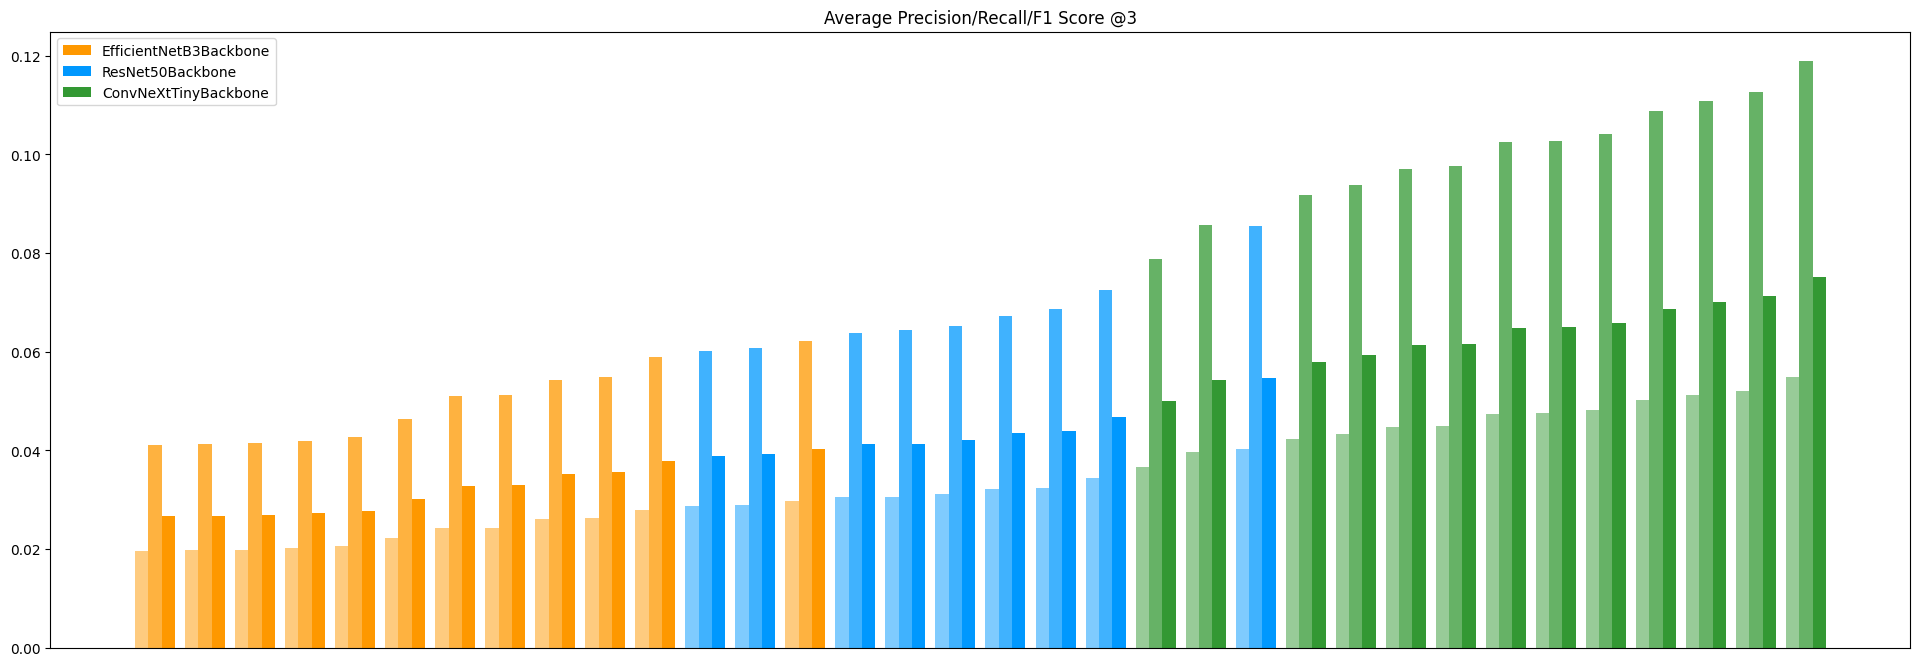

In [61]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([255/256, 153/256, 0/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_3"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_3"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_3"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @3")

###

plt.show()

In [62]:
print("\\begin{tabular}{l", end="")
for _ in range(len(ord_df)):
    print("c", end="")
print("}", end="")
print()

###

print("Batch Size", end="")
for batch_size in ord_df["loading_batch_size"]:
    print(" & {:d}".format(batch_size), end="")
print(" \\\\")

###

print("Grad Accum. Iters", end="")
for stage_1_grad_acc_iters, stage_2_grad_acc_iters in zip(ord_df["stage_1_grad_acc_iters"], ord_df["stage_2_grad_acc_iters"]):
    print(" & {:d}".format(stage_2_grad_acc_iters), end="")
print(" \\\\")

###

print("Learning Rate (S1)", end="")
for stage_1_lr in ord_df["stage_1_lr"]:
    print(" & {:.1e}".format(float(stage_1_lr)), end="")
print(" \\\\")

###

print("Learning Rate (S2)", end="")
for stage_2_lr in ord_df["stage_2_lr"]:
    print(" & {:.1e}".format(float(stage_2_lr)), end="")
print(" \\\\")

###

print("Number of GPUs", end="")
for num_gpus in ord_df["num_gpus"]:
    print(" & {:d}".format(num_gpus), end="")

\begin{tabular}{lcccccccccccccccccccccccccccccccccc}
Batch Size & 64 & 64 & 32 & 16 & 32 & 16 & 64 & 64 & 32 & 16 & 32 & 32 & 32 & 16 & 16 & 16 & 8 & 32 & 8 & 16 & 64 & 32 & 8 & 64 & 16 & 64 & 32 & 32 & 16 & 64 & 16 & 16 & 32 & 16 \\
Grad Accum. Iters & 8 & 8 & 4 & 2 & 4 & 2 & 8 & 8 & 4 & 2 & 4 & 1 & 1 & 2 & 1 & 1 & 1 & 1 & 1 & 1 & 2 & 1 & 1 & 2 & 1 & 2 & 1 & 1 & 1 & 2 & 2 & 1 & 1 & 1 \\
Learning Rate (S1) & 1.0e-02 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-02 & 1.0e-03 & 1.0e-05 & 1.0e-04 & 1.0e-03 & 1.0e-04 & 1.0e-05 & 1.0e-04 & 1.0e-03 & 1.0e-05 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-02 \\
Learning Rate (S2) & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-05 & 1.0e-05 & 1.0e-05 & 1.0e-05 & 1.0e-05 & 5.0e-06 & 5.0e-05 & 1.0e-05 & 5.0e-05 & 5.0e-06 & 5.0e-05 & 5.0e-04 & 5.0e-06 & 5.0e-04 & 1.0e-06 & 1.0e-06 & 5.0e-0

In [63]:
ord_df = df.sort_values("avg_test_f1_at_5", ascending=True)
ord_df = ord_df.reset_index(drop=True)

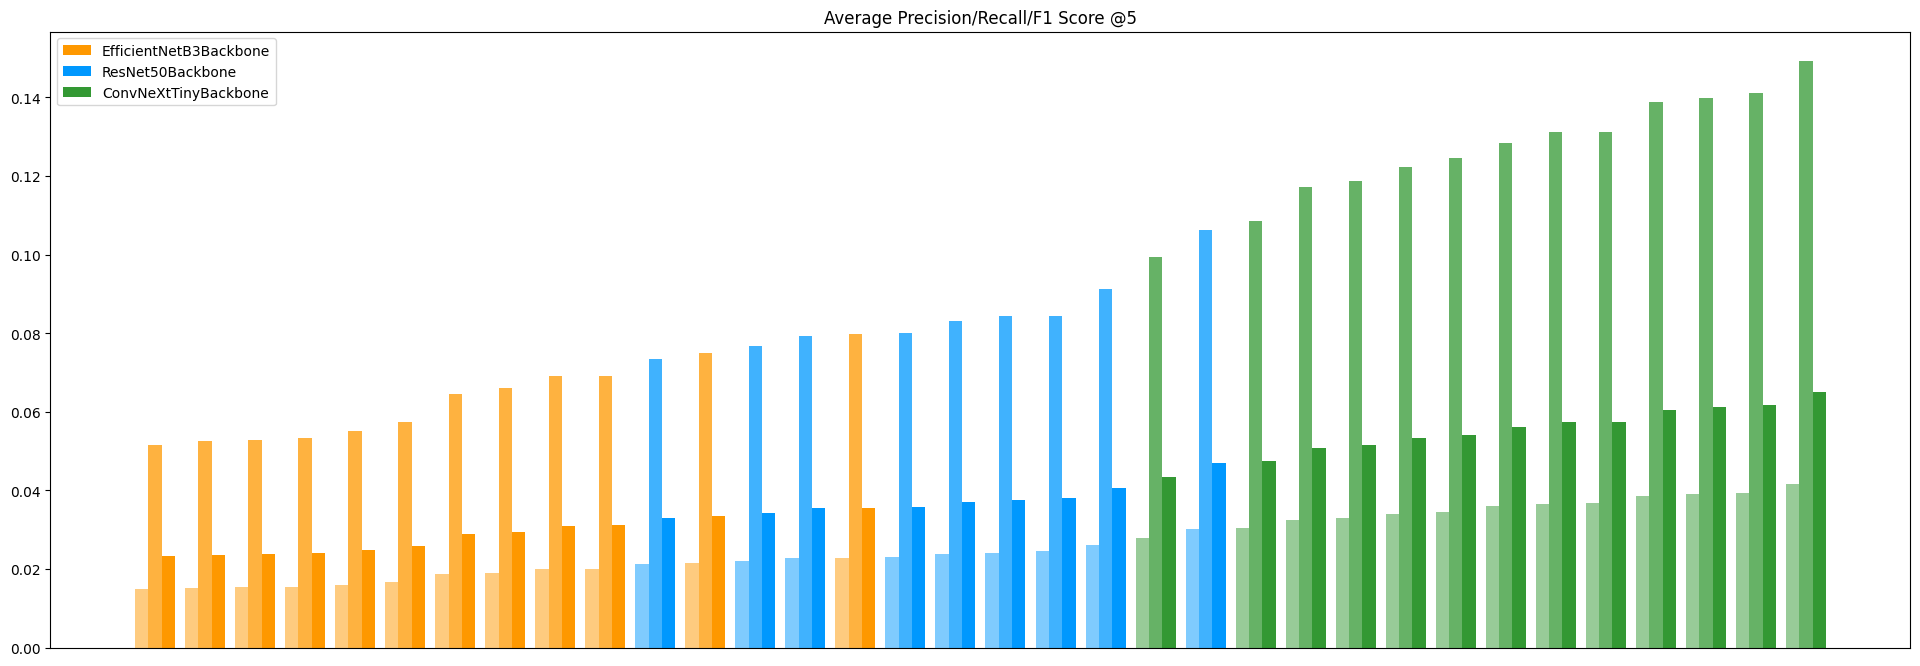

In [64]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([255/256, 153/256, 0/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_5"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_5"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_5"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @5")

###

plt.show()

In [65]:
print("\\begin{tabular}{l", end="")
for _ in range(len(ord_df)):
    print("c", end="")
print("}", end="")
print()

###

print("Batch Size", end="")
for batch_size in ord_df["loading_batch_size"]:
    print(" & {:d}".format(batch_size), end="")
print(" \\\\")

###

print("Grad Accum. Iters", end="")
for stage_1_grad_acc_iters, stage_2_grad_acc_iters in zip(ord_df["stage_1_grad_acc_iters"], ord_df["stage_2_grad_acc_iters"]):
    print(" & {:d}".format(stage_2_grad_acc_iters), end="")
print(" \\\\")

###

print("Learning Rate (S1)", end="")
for stage_1_lr in ord_df["stage_1_lr"]:
    print(" & {:.1e}".format(float(stage_1_lr)), end="")
print(" \\\\")

###

print("Learning Rate (S2)", end="")
for stage_2_lr in ord_df["stage_2_lr"]:
    print(" & {:.1e}".format(float(stage_2_lr)), end="")
print(" \\\\")

###

print("Number of GPUs", end="")
for num_gpus in ord_df["num_gpus"]:
    print(" & {:d}".format(num_gpus), end="")

\begin{tabular}{lcccccccccccccccccccccccccccccccccc}
Batch Size & 32 & 64 & 64 & 16 & 32 & 16 & 64 & 64 & 16 & 32 & 32 & 32 & 32 & 16 & 16 & 16 & 8 & 8 & 32 & 16 & 64 & 8 & 32 & 64 & 16 & 64 & 32 & 32 & 64 & 16 & 16 & 16 & 32 & 16 \\
Grad Accum. Iters & 4 & 8 & 8 & 2 & 4 & 2 & 8 & 8 & 2 & 4 & 1 & 4 & 1 & 1 & 2 & 1 & 1 & 1 & 1 & 1 & 2 & 1 & 1 & 2 & 1 & 2 & 1 & 1 & 2 & 1 & 2 & 1 & 1 & 1 \\
Learning Rate (S1) & 1.0e-02 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-02 & 1.0e-05 & 1.0e-03 & 1.0e-04 & 1.0e-05 & 1.0e-03 & 1.0e-04 & 1.0e-04 & 1.0e-05 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-02 \\
Learning Rate (S2) & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-05 & 1.0e-05 & 1.0e-05 & 1.0e-05 & 5.0e-06 & 1.0e-05 & 5.0e-05 & 5.0e-06 & 1.0e-05 & 5.0e-05 & 5.0e-05 & 5.0e-06 & 5.0e-04 & 5.0e-04 & 1.0e-06 & 5.0e-04 & 1.0e-0

In [66]:
ord_df = df.sort_values("avg_test_f1_at_10", ascending=True)
ord_df = ord_df.reset_index(drop=True)

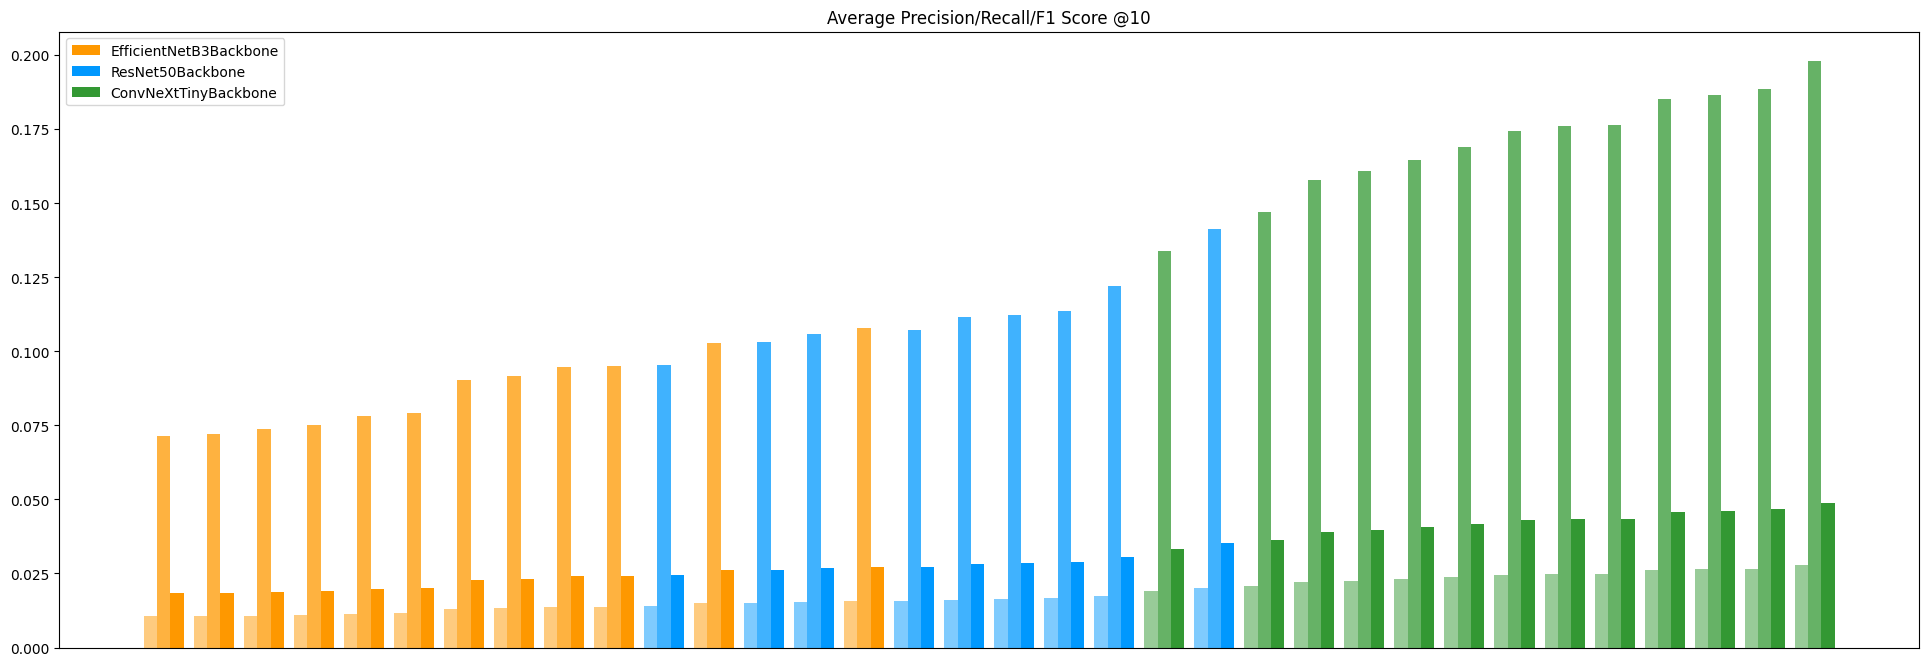

In [67]:
plt.figure(figsize=(24, 8))

###

bar_width = 0.8

for backbone in ord_df["backbone"].unique():

    ord_df_filt = ord_df[ord_df["backbone"] == backbone]
    
    if backbone == "ResNet50Backbone": backbone_color = np.asarray([0/256, 153/256, 255/256])
    if backbone == "EfficientNetB3Backbone": backbone_color = np.asarray([255/256, 153/256, 0/256])
    if backbone == "ConvNeXtTinyBackbone": backbone_color = np.asarray([51/256, 153/256, 51/256])

    plt.bar(np.asarray(ord_df_filt.index) - bar_width/3, ord_df_filt["avg_test_p_at_10"], width=bar_width/3, color=backbone_color, alpha=0.5)
    plt.bar(np.asarray(ord_df_filt.index), ord_df_filt["avg_test_r_at_10"], width=bar_width/3, color=backbone_color, alpha=0.75)
    plt.bar(np.asarray(ord_df_filt.index) + bar_width/3, ord_df_filt["avg_test_f1_at_10"], width=bar_width/3, label=backbone, color=backbone_color, alpha=1)

plt.legend()

###

plt.xticks([])
plt.title("Average Precision/Recall/F1 Score @10")

###

plt.show()

In [68]:
print("\\begin{tabular}{l", end="")
for _ in range(len(ord_df)):
    print("c", end="")
print("}", end="")
print()

###

print("Batch Size", end="")
for batch_size in ord_df["loading_batch_size"]:
    print(" & {:d}".format(batch_size), end="")
print(" \\\\")

###

print("Grad Accum. Iters", end="")
for stage_1_grad_acc_iters, stage_2_grad_acc_iters in zip(ord_df["stage_1_grad_acc_iters"], ord_df["stage_2_grad_acc_iters"]):
    print(" & {:d}".format(stage_2_grad_acc_iters), end="")
print(" \\\\")

###

print("Learning Rate (S1)", end="")
for stage_1_lr in ord_df["stage_1_lr"]:
    print(" & {:.1e}".format(float(stage_1_lr)), end="")
print(" \\\\")

###

print("Learning Rate (S2)", end="")
for stage_2_lr in ord_df["stage_2_lr"]:
    print(" & {:.1e}".format(float(stage_2_lr)), end="")
print(" \\\\")

###

print("Number of GPUs", end="")
for num_gpus in ord_df["num_gpus"]:
    print(" & {:d}".format(num_gpus), end="")

\begin{tabular}{lcccccccccccccccccccccccccccccccccc}
Batch Size & 32 & 64 & 64 & 16 & 32 & 16 & 64 & 64 & 32 & 16 & 32 & 32 & 32 & 16 & 16 & 16 & 8 & 8 & 32 & 16 & 64 & 8 & 32 & 64 & 16 & 64 & 32 & 32 & 64 & 16 & 16 & 16 & 32 & 16 \\
Grad Accum. Iters & 4 & 8 & 8 & 2 & 4 & 2 & 8 & 8 & 4 & 2 & 1 & 4 & 1 & 1 & 2 & 1 & 1 & 1 & 1 & 1 & 2 & 1 & 1 & 2 & 1 & 2 & 1 & 1 & 2 & 1 & 2 & 1 & 1 & 1 \\
Learning Rate (S1) & 1.0e-02 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-02 & 1.0e-05 & 1.0e-03 & 1.0e-04 & 1.0e-05 & 1.0e-03 & 1.0e-04 & 1.0e-05 & 1.0e-04 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-03 & 1.0e-02 & 1.0e-02 & 1.0e-03 & 1.0e-03 & 1.0e-02 & 1.0e-02 \\
Learning Rate (S2) & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-06 & 1.0e-05 & 1.0e-05 & 1.0e-05 & 1.0e-05 & 5.0e-06 & 1.0e-05 & 5.0e-05 & 5.0e-06 & 1.0e-05 & 5.0e-05 & 5.0e-06 & 5.0e-05 & 5.0e-04 & 5.0e-04 & 1.0e-06 & 5.0e-04 & 1.0e-0